# Data Cleaning: Coreset vs Random

## Purpose

The purpose of this example is to demonstrate how the DataHeroes' dataheroes library can be used to help you clean your data by easily identifying and fixing incorrectly labeled data as well as identifying other anomalies in your dataset such as data imbalance and under-represented domains. The library uses a methodology from computational geometry known as **coresets** to compute the importance of each data instance in your dataset, or how much this instance can affect your model. Individual instances with high importance usually indicate a labeling error or some anomaly or outlier.  
In this example, we're using the California housing prices dataset. Then we introduce noise into this dataset, by mislabeling some of the data instances of the train dataset. In the next step, we compare two cleaning methods, cleaning the data using coresets and cleaning the data using random sampling. 

Cleaning the data using coresets is simple and requires only a few lines of code. We first instantiate the `CoresetTreeServiceLR` class while `optimized_for='cleaning'` and build the Coreset service tree using the build function. Then in each cleaning iteration, we call the `.get_cleaning_samples()` method to retrieve samples that have high importance, which usually indicates a labeling error or other anomaly. In each iteration we also call the `update_targets` method to update the labels of the mislabeled samples.  

Finally, we have a couple of plots comparing the cleaning results of both methods, using coresets and randomly. As can be seen, using coresets, we were able to identify many, many more mislabeled instances in our dataset, which make coresets a great way to clean data. The same methodology can be easily applied to your dataset too!



In [1]:
import copy

import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from tqdm.notebook import tqdm

from dataheroes import CoresetTreeServiceLR

## Load California housing price dataset
To view more information about the dataset please refer to the next <a href="https://www.kaggle.com/datasets/camnugent/california-housing-prices"> link  </a>

In [2]:
X, y = fetch_california_housing(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

## Initialize a Linear Regression 



In [3]:
reg_params = {'n_jobs': -1}
reg = LinearRegression(**reg_params)

## Define the evaluation method

In [4]:
def eval_reg(X_train, y_train_to_eval):
    reg.fit(X_train, y_train_to_eval)
    y_pred = reg.predict(X_test)
    score = r2_score(y_test, y_pred)
    return score 

## Evaluate model on the clean data

In [5]:
score_clean = eval_reg(X_train, y_train)

##  Randomly mislabeling data
We select some random indexes. We mask values lower than median, and replace them with values above the 90% percentile. The ones above the median we replace with values in the 10% percentile.

In [6]:
#Calculate the median value of the dataset
median_price = np.median(y_train)
max_price = np.max(y_train)
min_price = np.min(y_train)
#Create 10 deciles in the range if min_price and max_price
deciles = np.quantile(y_train, np.arange(0.1, 1, 0.1))
# Initialize a list to store the modified y_train values
y_train_modified = copy.deepcopy(y_train)
num_samples_to_modify = 500

# We select some random indexes. We mask values lower than median, and replace them with values above the 90% percentile. 
# The ones above the median we replace with values in the 10% percentile.
idxs = np.random.choice(len(y_train_modified), size = num_samples_to_modify, replace = False)
mask_lower = y_train_modified[idxs] < median_price
y_train_modified[idxs[~mask_lower]] = np.random.uniform(min_price, deciles[0], size =  sum(~mask_lower))
y_train_modified[idxs[mask_lower]] = np.random.uniform(deciles[8], max_price, size =  sum(mask_lower))


## Evaluate before cleaning

In [7]:
score_before_cleaning = eval_reg(X_train, y_train_modified)

## Fix labels simulation method

In [8]:
def fix_labels(y_train_to_fix, idxs):
    """In reality this is a manual procedure, but in this simulation, we know the correct and original label"""
    y_train_to_fix[idxs] = y_train[idxs]
    return y_train_to_fix

## Set cleaning params

In [9]:
n_iterations = 10
n_samples_per_iter = 100

## Clean data using the coreset service

In [10]:
coreset_result = {'score': [score_before_cleaning], 'fixed': [0], 'viewed': [0]}
y_train_noise = copy.deepcopy(y_train_modified)
viewed_indices = np.array([], dtype = int)
dataset_indices = np.arange(0, len(X_train), dtype=int)

service = CoresetTreeServiceLR(optimized_for='cleaning', n_instances=len(y_train_noise))
service.build(X_train, y_train_noise, indices=dataset_indices)

for i in range(n_iterations):
    # Returns indices of most important samples order by importance.
    result = service.get_cleaning_samples(
        size = n_samples_per_iter
    )
    
    important_samples = result['idx']
    y_train_noise = fix_labels(y_train_noise, important_samples)
    # Update the labels of the mislabeled samples in the Coreset tree   
    service.update_targets(
        indices=important_samples,
        y=y_train_noise[important_samples],
    )

    viewed_indices = np.concatenate([viewed_indices, important_samples])
    score = eval_reg(X_train, y_train_noise)
    fixed = np.sum(y_train_noise != y_train_modified)
    coreset_result['score'].append(score)
    coreset_result['fixed'].append(fixed)
    coreset_result['viewed'].append(len(viewed_indices))

## Clean data using random sampling

In [11]:
random_result = {'score': [score_before_cleaning], 'fixed': [0], 'viewed': [0]}
y_train_noise = copy.deepcopy(y_train_modified)
viewed_indices = np.array([], dtype = int)
for i in range(n_iterations):
    rand_idxs = np.random.choice(dataset_indices, n_samples_per_iter, replace=False)
    rand_idxs = np.setdiff1d(rand_idxs, viewed_indices)
    np.random.shuffle(rand_idxs)
    y_train_noise = fix_labels(y_train_noise, rand_idxs)
    viewed_indices = np.concatenate([viewed_indices, rand_idxs])
    score = eval_reg(X_train,y_train_noise)
    fixed = np.sum(y_train_noise != y_train_modified)
    random_result['score'].append(score)
    random_result['fixed'].append(fixed)
    random_result['viewed'].append(len(viewed_indices))

## Plot R2 chart

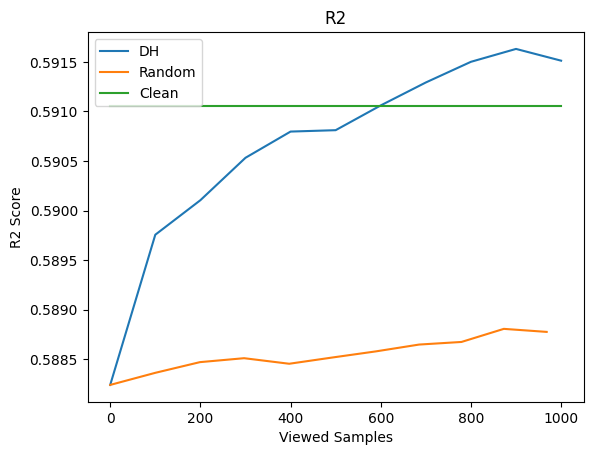

In [12]:
plt.plot(coreset_result["viewed"],coreset_result["score"], label="DH")
plt.plot(random_result["viewed"], random_result["score"],label="Random")
plt.plot(coreset_result["viewed"], np.ones(len(coreset_result["viewed"])) * score_clean, label="Clean")
plt.ylabel("R2 Score")
plt.xlabel("Viewed Samples")
plt.title("R2")
plt.legend()
plt.show(block=False)

## Plot Fixed chart

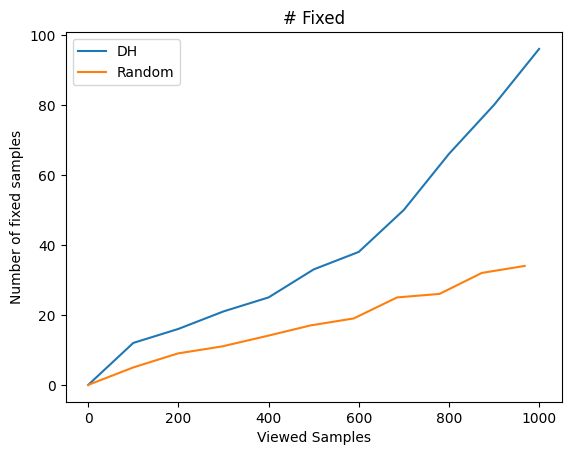

In [13]:
plt.plot(coreset_result["viewed"], coreset_result["fixed"], label="DH")
plt.plot(random_result["viewed"], random_result["fixed"], label="Random")
plt.ylabel("Number of fixed samples")
plt.xlabel("Viewed Samples")
plt.title("# Fixed")
plt.legend()
plt.show(block=False)